### 클래스별 부족한 데이터(1500개 이하)를 증강하는 코드

In [1]:
import os
import cv2
import random
from glob import glob
from imgaug import augmenters as iaa
import shutil

# 설정
DATASET_PATH = '/home/ted/dev_ws/deeplearing_pj/mask/tolabel/last/yolo11/YOLODataset/'
THRESHOLD = 1500  # 최소 이미지 수
AUG_PER_IMAGE = 2  # 증강할 이미지당 생성 수

IMG_PATH = os.path.join(DATASET_PATH, 'images', 'train')
LABEL_PATH = os.path.join(DATASET_PATH, 'labels', 'train')

# 증강기 정의
augmenter = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-10, 10)),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0, 1.0))
])

# 클래스별 이미지 수 세기
class_count = {}
image_files = glob(os.path.join(LABEL_PATH, '*.txt'))
for label_file in image_files:
    with open(label_file, 'r') as f:
        for line in f:
            cls = line.split()[0]
            class_count[cls] = class_count.get(cls, 0) + 1

# 증강 대상 클래스 선택
target_classes = [cls for cls, count in class_count.items() if count < THRESHOLD]
print(f"증강 대상 클래스: {target_classes}")

# 증강 실행
for label_file in image_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        classes_in_file = [line.split()[0] for line in lines]

    # 해당 파일에 증강 대상 클래스가 하나라도 있으면
    if any(cls in target_classes for cls in classes_in_file):
        img_file = os.path.join(IMG_PATH, os.path.basename(label_file).replace('.txt', '.jpg'))
        if not os.path.exists(img_file):
            img_file = img_file.replace('.jpg', '.png')
            if not os.path.exists(img_file): continue

        image = cv2.imread(img_file)
        h, w = image.shape[:2]

        for i in range(AUG_PER_IMAGE):
            aug_image = augmenter(image=image)

            new_img_name = os.path.basename(img_file).replace('.jpg', f'_aug{i}.jpg').replace('.png', f'_aug{i}.png')
            new_img_path = os.path.join(IMG_PATH, new_img_name)
            new_label_path = os.path.join(LABEL_PATH, new_img_name.replace('.jpg', '.txt').replace('.png', '.txt'))

            cv2.imwrite(new_img_path, aug_image)
            shutil.copy(label_file, new_label_path)

print("✅ 증강 완료!")


증강 대상 클래스: ['7', '4', '2', '8', '6', '9']
✅ 증강 완료!


In [2]:
import os
from glob import glob

LABEL_PATH = '/home/ted/dev_ws/deeplearing_pj/mask/tolabel/last/yolo11/YOLODataset/labels/train'

class_count = {}
image_files = glob(os.path.join(LABEL_PATH, '*.txt'))

for label_file in image_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        classes_in_file = set(line.split()[0] for line in lines)  # 중복 방지

        for cls in classes_in_file:
            class_count[cls] = class_count.get(cls, 0) + 1

# 결과 출력 (클래스 번호순으로 정렬)
for cls in sorted(class_count.keys(), key=lambda x: int(x)):
    print(f"클래스 {cls} : {class_count[cls]}개 이미지")


클래스 0 : 2308개 이미지
클래스 1 : 3319개 이미지
클래스 2 : 985개 이미지
클래스 3 : 3032개 이미지
클래스 4 : 1394개 이미지
클래스 5 : 2014개 이미지
클래스 6 : 1333개 이미지
클래스 7 : 1935개 이미지
클래스 8 : 1491개 이미지
클래스 9 : 174개 이미지


### 라벨링이 사진에서 어떻게 되어있는지 확인하는 코드

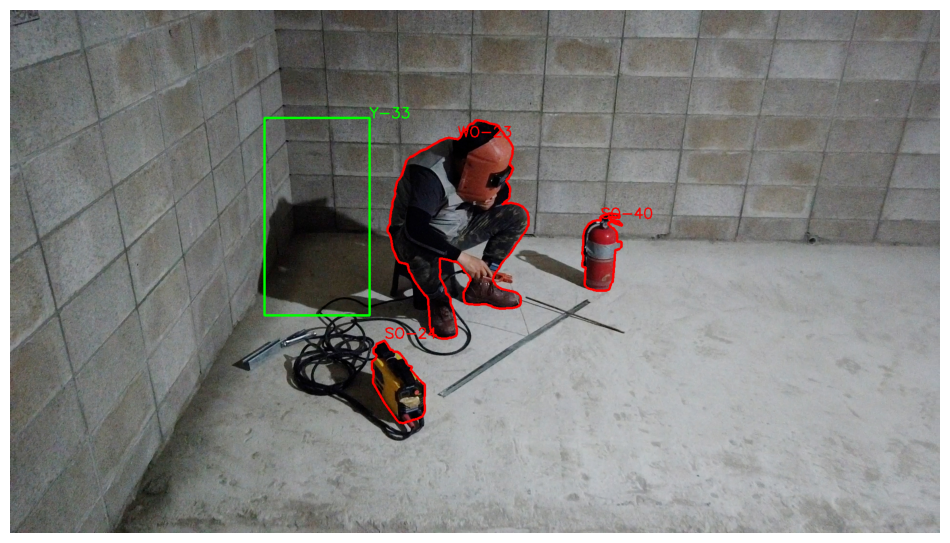

In [3]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# JSON 파일 경로
json_path = '/home/ted/dev_ws/deeplearing_pj/mask/tolabel/Y_33/라빌렝데이터Y_33/H-220701_D16_Y-33_001_0021.json'
# 이미지 파일 경로
image_path = '/home/ted/dev_ws/deeplearing_pj/mask/tolabel/Y_33/원천데이터Y_33/H-220701_D16_Y-33_001_0021.jpg'
# JSON 로드
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 이미지 로드 (OpenCV는 기본 BGR이므로 나중에 RGB로 변환)
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"이미지 파일을 찾을 수 없습니다: {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Annotations 추출
annotations = data["Learning_Data_Info."]["Annotations"]

for ann in annotations:
    ann_type = ann["type"]
    coords = ann["value"]
    class_id = ann["class_ID"]
    
    if ann_type == "polygon":
        # 폴리곤인 경우 [x1, y1, x2, y2, ...] 형태이므로,
        # 2개씩 묶어서 (x, y) 좌표 리스트로 변환
        pts = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
        pts_np = np.array(pts, dtype=np.int32).reshape((-1, 1, 2))
        
        # 폴리곤 그리기
        cv2.polylines(image, [pts_np], isClosed=True, color=(255, 0, 0), thickness=3)
        
        # 첫 번째 점 근처에 클래스 ID 표시
        x_text, y_text = pts[0]
        cv2.putText(image, class_id, (int(x_text), int(y_text) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    elif ann_type == "bbox":
        # bbox인 경우 [x_min, y_min, x_max, y_max]
        x_min, y_min, x_max, y_max = coords
        pt1 = (int(x_min), int(y_min))
        pt2 = (int(x_max), int(y_max))
        
        # 사각형 그리기
        cv2.rectangle(image, pt1, pt2, (0, 255, 0), 3)
        
        # 왼쪽 상단에 클래스 ID 표시
        cv2.putText(image, class_id, pt1,
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# 시각화
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


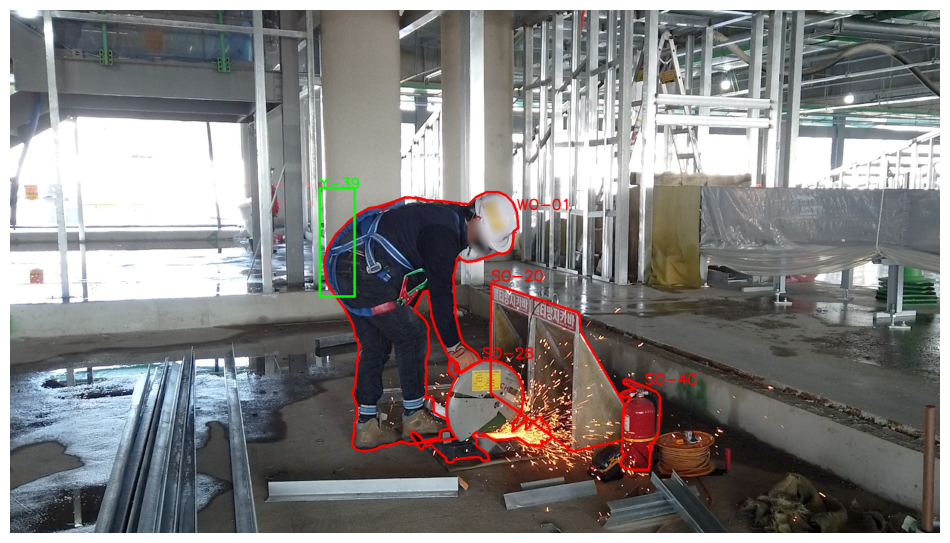

In [6]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# JSON 파일 경로
json_path = '/home/ted/dev_ws/deeplearing_pj/mask/tolabel/Y_39/labely39/TL_5대사고유형_화재_정상_Y-39.zip/H-221011_D18_Y-39_002_0225.json'
# 이미지 파일 경로
image_path = '/home/ted/dev_ws/deeplearing_pj/mask/tolabel/Y_39/originy39/H-221011_D18_Y-39_002_0225.jpg'
# JSON 로드
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 이미지 로드 (OpenCV는 기본 BGR이므로 나중에 RGB로 변환)
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"이미지 파일을 찾을 수 없습니다: {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Annotations 추출
annotations = data["Learning_Data_Info."]["Annotations"]

for ann in annotations:
    ann_type = ann["type"]
    coords = ann["value"]
    class_id = ann["class_ID"]
    
    if ann_type == "polygon":
        # 폴리곤인 경우 [x1, y1, x2, y2, ...] 형태이므로,
        # 2개씩 묶어서 (x, y) 좌표 리스트로 변환
        pts = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
        pts_np = np.array(pts, dtype=np.int32).reshape((-1, 1, 2))
        
        # 폴리곤 그리기
        cv2.polylines(image, [pts_np], isClosed=True, color=(255, 0, 0), thickness=3)
        
        # 첫 번째 점 근처에 클래스 ID 표시
        x_text, y_text = pts[0]
        cv2.putText(image, class_id, (int(x_text), int(y_text) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    elif ann_type == "bbox":
        # bbox인 경우 [x_min, y_min, x_max, y_max]
        x_min, y_min, x_max, y_max = coords
        pt1 = (int(x_min), int(y_min))
        pt2 = (int(x_max), int(y_max))
        
        # 사각형 그리기
        cv2.rectangle(image, pt1, pt2, (0, 255, 0), 3)
        
        # 왼쪽 상단에 클래스 ID 표시
        cv2.putText(image, class_id, pt1,
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# 시각화
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


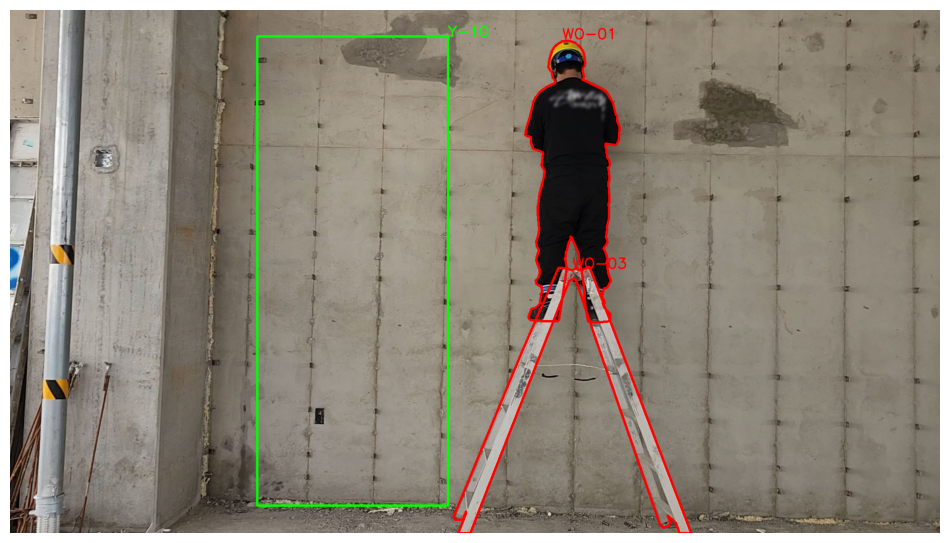

In [8]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# JSON 파일 경로
json_path = '/home/ted/dev_ws/deeplearing_pj/mask/tolabel/Y_10/labely10/TL_5대사고유형_추락_정상_Y-10.zip/H-220707_A32_Y-10_011_0024.json'
# 이미지 파일 경로
image_path = '/home/ted/dev_ws/deeplearing_pj/mask/tolabel/Y_10/originy10/H-220707_A32_Y-10_011_0024.jpg'
# JSON 로드
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 이미지 로드 (OpenCV는 기본 BGR이므로 나중에 RGB로 변환)
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"이미지 파일을 찾을 수 없습니다: {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Annotations 추출
annotations = data["Learning_Data_Info."]["Annotations"]

for ann in annotations:
    ann_type = ann["type"]
    coords = ann["value"]
    class_id = ann["class_ID"]
    
    if ann_type == "polygon":
        # 폴리곤인 경우 [x1, y1, x2, y2, ...] 형태이므로,
        # 2개씩 묶어서 (x, y) 좌표 리스트로 변환
        pts = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
        pts_np = np.array(pts, dtype=np.int32).reshape((-1, 1, 2))
        
        # 폴리곤 그리기
        cv2.polylines(image, [pts_np], isClosed=True, color=(255, 0, 0), thickness=3)
        
        # 첫 번째 점 근처에 클래스 ID 표시
        x_text, y_text = pts[0]
        cv2.putText(image, class_id, (int(x_text), int(y_text) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    elif ann_type == "bbox":
        # bbox인 경우 [x_min, y_min, x_max, y_max]
        x_min, y_min, x_max, y_max = coords
        pt1 = (int(x_min), int(y_min))
        pt2 = (int(x_max), int(y_max))
        
        # 사각형 그리기
        cv2.rectangle(image, pt1, pt2, (0, 255, 0), 3)
        
        # 왼쪽 상단에 클래스 ID 표시
        cv2.putText(image, class_id, pt1,
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# 시각화
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


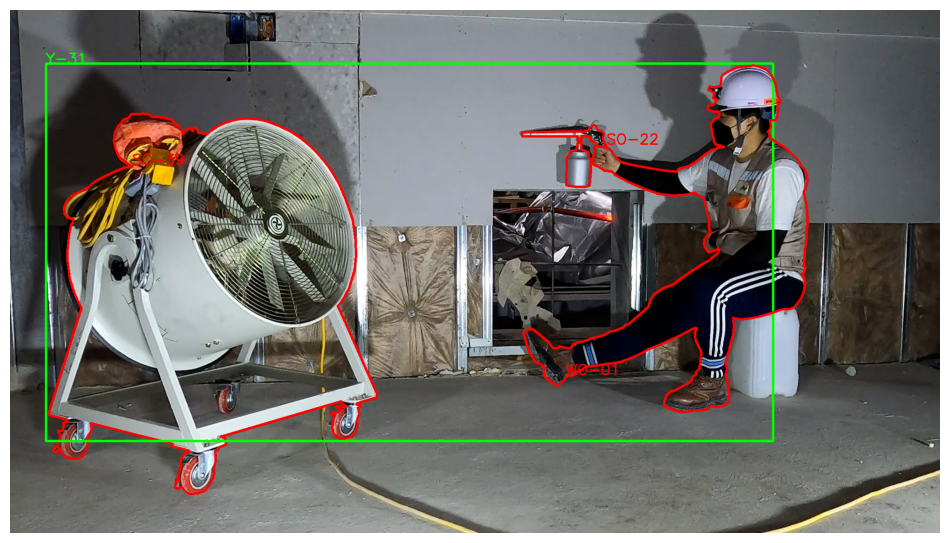

In [9]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# JSON 파일 경로
json_path = '/home/ted/dev_ws/deeplearing_pj/mask/tolabel/Y_31/label/TL_5대사고유형_화재_정상_Y-31.zip/H-220824_D31_Y-31_004_0108.json'
# 이미지 파일 경로
image_path = '/home/ted/dev_ws/deeplearing_pj/mask/tolabel/Y_31/origin/y31/H-220824_D31_Y-31_004_0108.jpg'
# JSON 로드
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 이미지 로드 (OpenCV는 기본 BGR이므로 나중에 RGB로 변환)
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"이미지 파일을 찾을 수 없습니다: {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Annotations 추출
annotations = data["Learning_Data_Info."]["Annotations"]

for ann in annotations:
    ann_type = ann["type"]
    coords = ann["value"]
    class_id = ann["class_ID"]
    
    if ann_type == "polygon":
        # 폴리곤인 경우 [x1, y1, x2, y2, ...] 형태이므로,
        # 2개씩 묶어서 (x, y) 좌표 리스트로 변환
        pts = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
        pts_np = np.array(pts, dtype=np.int32).reshape((-1, 1, 2))
        
        # 폴리곤 그리기
        cv2.polylines(image, [pts_np], isClosed=True, color=(255, 0, 0), thickness=3)
        
        # 첫 번째 점 근처에 클래스 ID 표시
        x_text, y_text = pts[0]
        cv2.putText(image, class_id, (int(x_text), int(y_text) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    elif ann_type == "bbox":
        # bbox인 경우 [x_min, y_min, x_max, y_max]
        x_min, y_min, x_max, y_max = coords
        pt1 = (int(x_min), int(y_min))
        pt2 = (int(x_max), int(y_max))
        
        # 사각형 그리기
        cv2.rectangle(image, pt1, pt2, (0, 255, 0), 3)
        
        # 왼쪽 상단에 클래스 ID 표시
        cv2.putText(image, class_id, pt1,
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# 시각화
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()
